In [2]:
import pandas as pd
import numpy as np
import ta
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gymnasium as gym
import math
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def create_subplots(n,df,st):
    fig, axes = plt.subplots(1, n, figsize=(7*n, 2*n))
    for i in range(n):
        data = df[i]['Open']
        axes[i].plot(data)
        axes[i].set_title(st[i][:-4])
    plt.show()
# n = len(dataframes)
# create_subplots(n,df=dataframes,st=stocks)

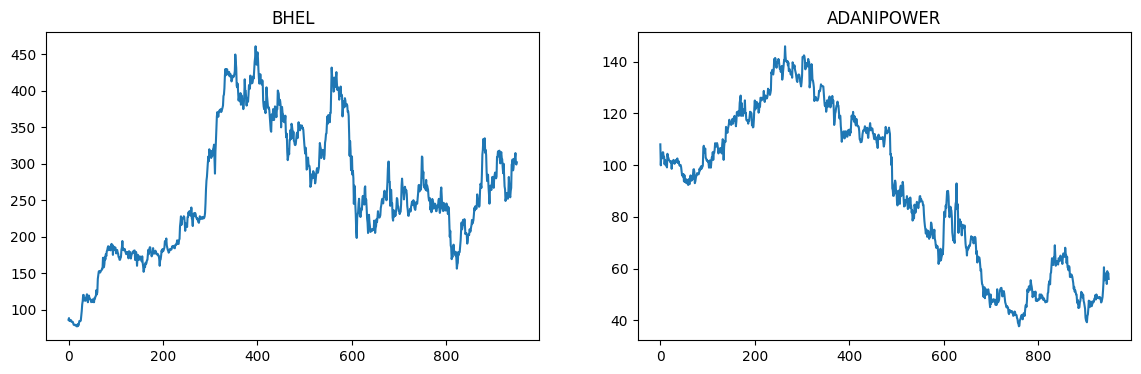

In [98]:
# test_stocks=['63MOONS.csv','BHEL.csv','BIOCON.csv','ADANIPOWER.csv']
# test_stocks=['63MOONS.csv','NHPC.csv','BIOCON.csv','BHEL.csv']
# 
# test_stocks=['BSOFT.csv','BIRLACORPN.csv','BLUECOAST.csv','BLUEDART.csv']
test_stocks=['BLUEDART.csv','BLUEDART.csv']
# test_stocks=['NHPC.csv','BLUEDART.csv']

# test_stocks=['btc_30m.csv','ETH_1H.csv']
# test_stocks=['ETH_1H.csv','btc_30m.csv']

# saved=[]
# test_stocks=['NHPC.csv','BLUEDART.csv']
test_stocks=['BHEL.csv','ADANIPOWER.csv']


test_dataframes=[]
# stocks=['63MOONS.csv']
path='/home/siddharth/Desktop/MultiTrading/Datasets/SCRIP/'
# path='/home/siddharth/Desktop/MultiTrading/'
timesteps=950
for name in test_stocks:
    df=pd.read_csv(path+name)
    df=df[:timesteps]
    df=df[['Open','Close','High','Low','Volume']]
    df.reset_index(inplace=True,drop=True)
    test_dataframes.append(df)
create_subplots(n=2,df=test_dataframes,st=test_stocks)

In [99]:
import ta

def preprocess(data):
    long_sma_window = 50
    short_sma_window = 20
    data['feature_Long_SMA'] = data['Close'].rolling(window=long_sma_window, min_periods=1).mean()
    data['feature_Short_SMA'] = data['Close'].rolling(window=short_sma_window, min_periods=1).mean()
    data['feature_RSI'] = ta.momentum.rsi(close=data['Close'], window=14)
    data["feature_Close"] = data["Close"].pct_change()
    data["feature_Open"] = data["Open"]/data["Close"]
    data["feature_High"] = data["High"]/data["Close"]
    data["feature_Low"] = data["Low"]/data["Close"] 
    data['feature_MACD'] = ta.trend.macd(data["Close"])
    data['feature_CCI'] = ta.trend.cci(data["High"], data["Low"], data["Close"], window=20)
    data['feature_BB_upper'], data['feature_BB_middle'], data['feature_BB_lower'] = ta.volatility.bollinger_hband(data["Close"]), ta.volatility.bollinger_mavg(data["Close"]), ta.volatility.bollinger_lband(data["Close"])
    data['feature_Slowk']= ta.momentum.stoch(data["High"], data["Low"], data["Close"])
    data['feature_ATR'] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=14)
    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)


In [100]:

import itertools
num_stocks=len(test_dataframes)
boxes=2*num_stocks
rng = list(range(boxes + 1)) * num_stocks
wt_combs=[]
lol=set(i for i in itertools.permutations(rng, num_stocks) if sum(i) == boxes)
for i in lol:
    wt_combs.append(i)
wt_combs=np.array(wt_combs)
wt_combs_norm=wt_combs/boxes
print((wt_combs_norm))


[[1.   0.  ]
 [0.   1.  ]
 [0.75 0.25]
 [0.5  0.5 ]
 [0.25 0.75]]


In [101]:
norm_test_dataframes=[]
for i in range(len(test_dataframes)):
    df=test_dataframes[i]
    preprocess(df)
    test_dataframes[i]=df
    df = (df - df.min()) / (df.max() - df.min())
    norm_test_dataframes.append(df)

In [102]:
from Env import MultiTradingEnv;
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Testing_arr = []
LOOKBACK=5
step=0.25
positions=np.arange(0,1,step)
positions=np.append(positions,1)
Test_Env = MultiTradingEnv(dataframes_array=test_dataframes,
                    norm_dataframes=norm_test_dataframes,
                    total_timesteps=len(test_dataframes[0])-LOOKBACK-1,
                    initial_cap=100000.0,
                    features=['feature_RSI','feature_Close','feature_MACD','feature_CCI','feature_Slowk','feature_ATR'],
                    # features=['feature_Long_SMA','feature_Short_SMA','feature_RSI','feature_Close','feature_MACD','feature_CCI','feature_BB_upper','feature_BB_middle','feature_BB_lower','feature_Slowk','feature_ATR'],
                    lookback=LOOKBACK,
                    positions=positions,
                    wt_combs=wt_combs_norm,
                    )

In [103]:
def discounted_cumulative_sums(x, discount):
    ls=[]
    for i in range(1):
        ls.append(scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1])
    # return np.array(ls)
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(shape=(size,env.num_stocks),dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros((size,env.num_stocks), dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = np.array(action)
        # print(self.action_buffer,action)
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1
        # print(self.pointer)


    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=keras.activations.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)


def logprobabilities(logits, a):
    
    # print(logits.shape,a.shape)
    # logits=logits.reshape(-1,env.num_stocks,len(env.positions))
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = keras.ops.log_softmax(logits)
    # print(logprobabilities_all.shape)
    logprobability = keras.ops.sum(
        keras.ops.one_hot(a, len(env.positions)) * logprobabilities_all, axis=1
    )
    # print(logprobability.shape)
    return logprobability
def logprobabilitiesall(logits, a):
    
    # print(logits.shape,a.shape)
    logits=logits.reshape(-1,env.num_stocks,len(env.positions))
    # print(logits.shape)
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = keras.ops.log_softmax(logits,axis=-1)
    # print(logprobabilities_all.shape)
    # print(logprobabilities_all.shape)
    logprobability = keras.ops.sum(
        keras.ops.one_hot(a, len(env.positions)) * logprobabilities_all, axis=2
    )
    # print(logprobability.shape)
    return logprobability

seed_generator = keras.random.SeedGenerator(1337)


# Sample action from actor
def sample_action(observation):
    logits = actor(observation)
    # print(logits.shape)
    logits=logits.reshape(env.num_stocks,-1)
    action = keras.ops.squeeze(
        keras.random.categorical(logits, 1, seed=seed_generator), axis=1
    )
    
    return logits, action


# Train the policy by maxizing the PPO-Clip objective
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):
    # print(actor(observation_buffer).shape,action_buffer.shape)
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = keras.ops.exp(
            logprobabilitiesall(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        # print(ratio)
        min_advantage = keras.ops.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -keras.ops.mean(
            keras.ops.minimum(ratio * np.array([advantage_buffer for i in range(env.num_stocks)]).reshape(-1,env.num_stocks), np.array([min_advantage for i in range(env.num_stocks)]).reshape(-1,env.num_stocks))
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = keras.ops.mean(
        logprobability_buffer
        - logprobabilitiesall(actor(observation_buffer), action_buffer)
    )
    kl = keras.ops.sum(kl)
    return kl


# Train the value function by regression on mean-squared error
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = keras.ops.mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))


In [104]:
tmp=np.zeros(shape=len(Test_Env.dataframes_array[0]))
cnt=0
wts=np.ones(num_stocks)/num_stocks
for i in Test_Env.dataframes_array:
    num=(100000*wts[cnt])/np.array(i['Open'][0])
    ar=np.array(i['Open'])*num
    tmp+=ar
    cnt+=1
tmp=tmp[5:-15]
tmp/=tmp[0]
tmp*=100000

In [105]:
import pandas_ta as ta

In [106]:
import numpy as np
import math

class Donchian:
    def __init__(self, stock_array, investment, timesteps):
        self.stock_array = stock_array
        self.investment = investment/len(self.stock_array)
        self.timesteps = timesteps
        self.net_worth = np.zeros(timesteps)
        
        
    def stratergy(self):
      for i in range(len(self.stock_array)):
        self.stock_array[i][['dcl', 'dcm', 'dcu']] = self.stock_array[i].ta.donchian(lower_length = 40, upper_length = 50)

    def implement_strategy(self):
        for aapl in self.stock_array:
            in_position = False
            equity = self.investment
            no_of_shares = 0
            self.net_worth[0] += self.investment
            for i in range(1, self.timesteps):
                if aapl['High'][i] == aapl['dcu'][i] and not in_position:
                    no_of_shares = math.floor(equity / aapl.Close[i])
                    equity -= (no_of_shares * aapl.Close[i])
                    in_position = True
                    self.net_worth[i] += (equity + no_of_shares * aapl.Close[i])
                elif aapl['Low'][i] == aapl['dcl'][i] and in_position:
                    equity += (no_of_shares * aapl.Close[i])
                    no_of_shares = 0
                    self.net_worth[i] += (equity + (no_of_shares * aapl.Close[i]))
                    in_position = False
                else:
                    self.net_worth[i] += (equity + (no_of_shares * aapl.Close[i]))
            if in_position:
                equity += (no_of_shares * aapl.Close[i])
                in_position = False

            earning = round(equity - self.investment, 2)
            roi = round(earning / self.investment * 100, 2)
            print(f'EARNING: ${earning} ; ROI: {roi}%')
        return self.net_worth


timesteps = 350
investment = 100000
final_portfolio_networth = np.zeros(timesteps)
stock_array = test_dataframes

strategy1 = Donchian(stock_array, investment, timesteps)
strategy1.stratergy()
net_worth = strategy1.implement_strategy()
# plt.plot(net_worth)
# plt.plot(tmp)
# plt.plot([Testing_arr[8][i][3] for i in range(len(Testing_arr[8]))],label=f'Ep{j*ep_step}')


EARNING: $51870.4 ; ROI: 103.74%
EARNING: $6967.3 ; ROI: 13.93%


Sortino Ratio: 0.05530315094802438
Sharpe Ratio: 0.03775319390542607
Maximum Drawdown: 0.5900115326333313
ep320 174179.64999999956
5 2 42 28
Sortino Ratio: 0.04860339553251699
Sharpe Ratio: 0.0337555349220159
Maximum Drawdown: 0.4182651749297446
ep330 143783.55000000028
5 2 94 18
Sortino Ratio: 0.084275356585872
Sharpe Ratio: 0.053841642470945736
Maximum Drawdown: 0.25585187592640307
ep340 185093.9499999995
6 2 51 16


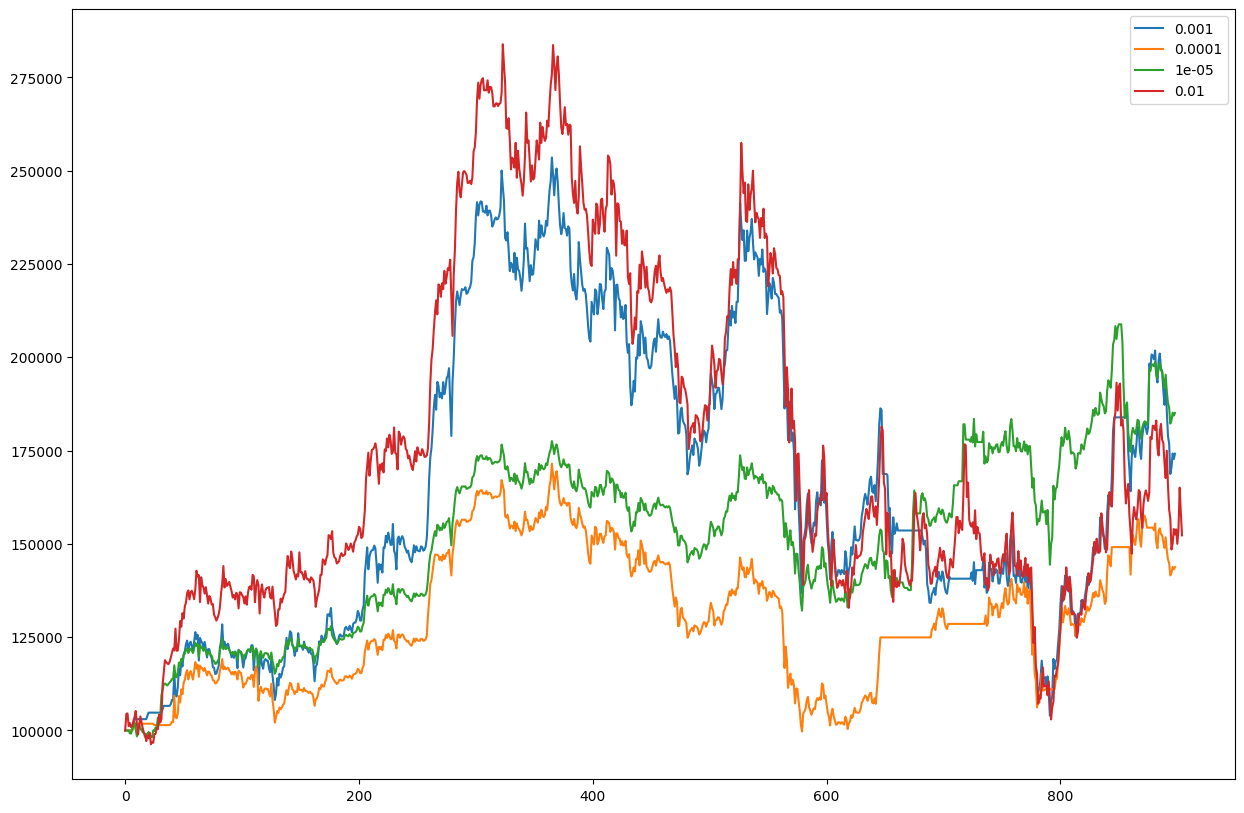

In [112]:
def sortino_ratio(returns, target_return=0):
    downside_returns = np.minimum(returns - target_return, 0)
    downside_deviation = np.sqrt(np.mean(np.square(downside_returns)))
    average_return = np.mean(returns)
    sortino_ratio = average_return / downside_deviation
    return 1+10*sortino_ratio
def sharpe_ratio(returns, risk_free_rate=0):
    average_return = np.mean(returns)
    std_deviation = np.std(returns)
    sharpe_ratio = (average_return - risk_free_rate) / std_deviation
    return 1+10*sharpe_ratio
def max_drawdown(prices):
    max_drawdown = 0
    peak = prices[0]
    for price in prices:
        if price > peak:
            peak = price
        drawdown = (peak - price) / peak
        max_drawdown = max(max_drawdown, drawdown)
    return max_drawdown
plt.figure(figsize=(15, 10))
lrs=[1e-3,1e-4,1e-5]
for j in range(320,341,10):
    state=Test_Env.reset()
    # print(state.features)
    n_observations = len(state.features.flatten())
    # print(n_observations)
    model = Policy(n_observations)
    model.load_state_dict(torch.load(f'/home/siddharth/Desktop/A2C/ep{j}.pth'))
    done= 0
    hist=[]
    st=set()
    prev1=()
    prev2=()
    cnt1=0
    cnt2=0
    st2=set()
    while not done:
        state = torch.tensor(state.features, dtype=torch.float32, device=device).unsqueeze(0)
        action, weight,_ = model(state.view(-1))
        action = action.transpose(1, 2)
        action=action.detach()
        weight=weight.detach()
        actions=[]
        # print(action,weight)
        # print(action)
        for i in range(Test_Env.num_stocks):
            m = np.argmax(action[0][i])
            actions.append(m.item())
        weight_m=torch.tensor([np.argmax(weight).item()])
        # print(Test_Env.current_step,wt_combs_norm[weight_m.item()],Test_Env.shares_held, Test_Env.balance,Test_Env.net_worth)
        # print(Test_Env.shares_held, Test_Env.balance)
        if(tuple(actions)!=prev1):
            cnt1+=1
            prev1=tuple(actions)
        if(tuple(wt_combs_norm[weight_m])!=prev2):
            cnt2+=1
            prev2=tuple(wt_combs_norm[weight_m])
        st.add(tuple(actions))
        st2.add(tuple(wt_combs_norm[weight_m]))
        # print(actions,weight_m,wt_combs_norm[weight_m])
        act=torch.tensor([actions])
        hist.append(Test_Env.net_worth)
        state, reward, done= Test_Env.step(act,weight_m)
    stock_prices = hist
    stock_returns = np.diff(stock_prices) / stock_prices[:-1]
    sortino = sortino_ratio(stock_returns)
    sharpe= sharpe_ratio(stock_returns)
    maxd=max_drawdown(stock_prices)
    print("Sortino Ratio:", sortino)
    print("Sharpe Ratio:", sharpe)
    print("Maximum Drawdown:", maxd)
    print(f'ep{j} {hist[-1]}')
    print(len(st),len(st2),cnt1,cnt2)
    # plt.plot(hist,label=f'ep{j}')
    np.save('PPO.npy',hist)
    # saved.append(hist)
plt.plot(tmp,label=0.01)
# plt.plot(net_worth,label='D/S')
plt.legend()
plt.show()

Sortino Ratio: 0.05512567197657198
Sharpe Ratio: 0.03682218278777714
Maximum Drawdown: 0.6751965999032907


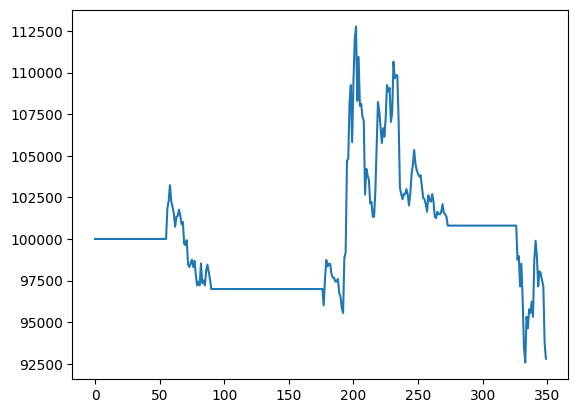

In [80]:
plt.plot(net_worth)
stock_prices = tmp
stock_returns = np.diff(stock_prices) / stock_prices[:-1]
sortino = sortino_ratio(stock_returns)
sharpe= sharpe_ratio(stock_returns)
maxd=max_drawdown(stock_prices)
print("Sortino Ratio:", sortino)
print("Sharpe Ratio:", sharpe)
print("Maximum Drawdown:", maxd)